This project builds and trains models to predict the likelihood of winning a game of DoTA.
A comparative analysis is done by training different types of classification models. Types of 
models implemented:  
 - Logistic Regression
 - Naive Bayes
 - Random Forest Classifier
 
The model performance is assessed using the metrics:
- Accuracy 
- Precision 
- Recall 
- F1 scores

The models are compared using the Precision-Recall (PR) curve and ROC-AUC curves.
A key insight from the project is that the selected features are not sufficient for good predictions on the probability of wins. Additional features about the specific heroes and team history will likely be better predictors. This is a possible future extension of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

The data is read from a csv file into tabular format into a pandas dataframe. The features include cluster_id,game_mode,game_type and hero selection and the label is result. Column headers are added from a json file. Data quality checks and corrections are applied.

In [2]:
db = pd.read_csv(r"C:\Users\rishi\ml_projects\dota\dota2Train.csv",header=None)
with open(r"C:\Users\rishi\ml_projects\dota\heroes.json", 'r') as f:
    data = json.load(f)
names=["result","cluster_id","game_mode","game_type"]
for i in range(0,113):
    names.append(data["heroes"][i]["localized_name"])

test = pd.read_csv(r"C:\Users\rishi\ml_projects\dota\dota2Test.csv")
test.columns=names
test=test.drop(["Wisp", "Abyssal Underlord"],axis=1)
db.columns=names
db=db.drop(["Wisp","Abyssal Underlord"],axis=1)
warnings.filterwarnings('ignore')

In [3]:
db.head()

,result,cluster_id,game_mode,game_type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


Plot of the Frequency Distribution of the heroes played. We see that there is an uneven distribution with only a few heroes played frequently and the rest are played very sparsely.

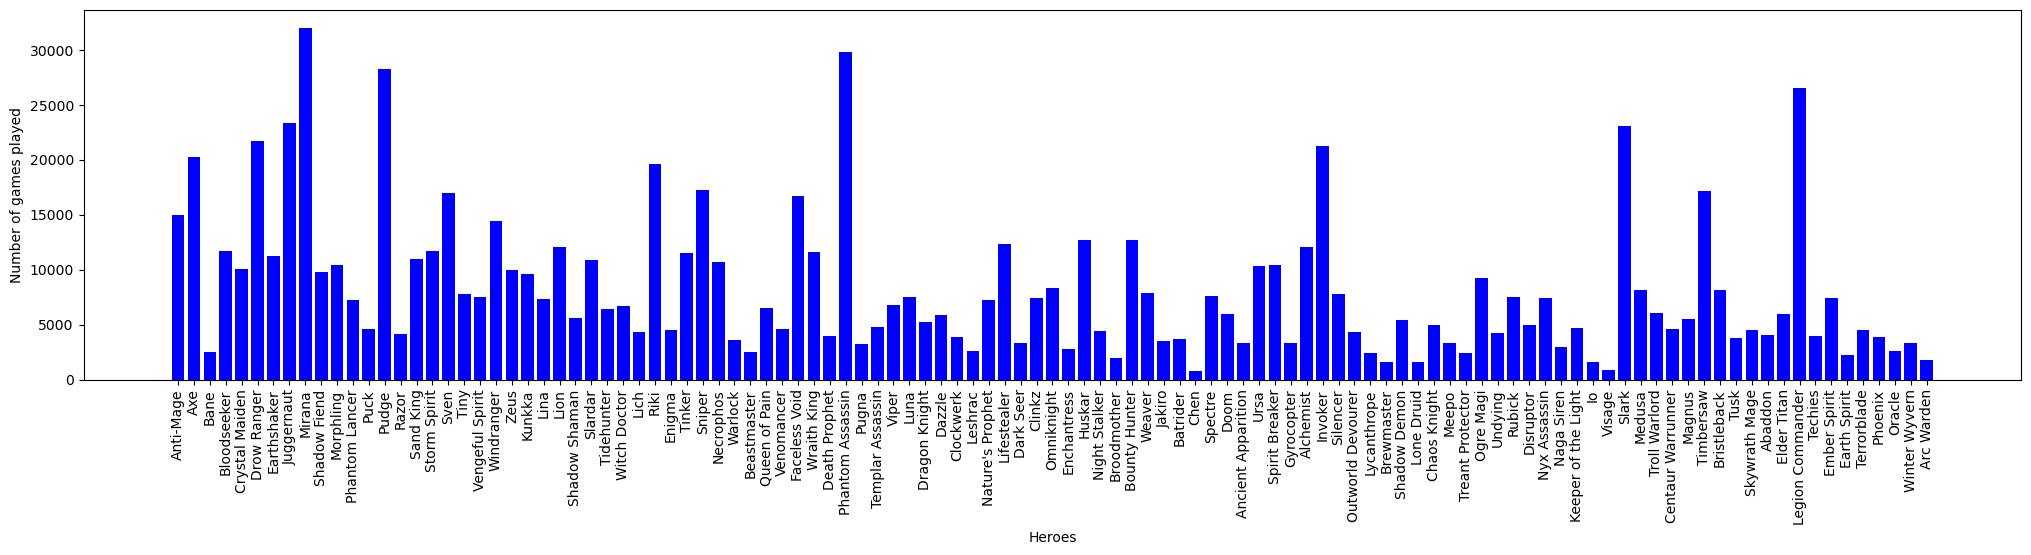

In [3]:
freq_x=[]
freq_y=[]
for i in db.columns[4:]:
    x=0
    y=0
    if 1 in db[i].value_counts():
        x=db[i].value_counts()[1]
    if -1 in db[i].value_counts():
        y=db[i].value_counts()[-1]
    
    freq_y.append(x+y)
plt.figure().set_figwidth(25)
plt.bar(db.columns[4:],freq_y,color="b")
plt.xlabel("Heroes")
plt.ylabel("Number of games played")
plt.xticks(rotation=90)
plt.show()

Plot of the number of wins and losses for each hero.

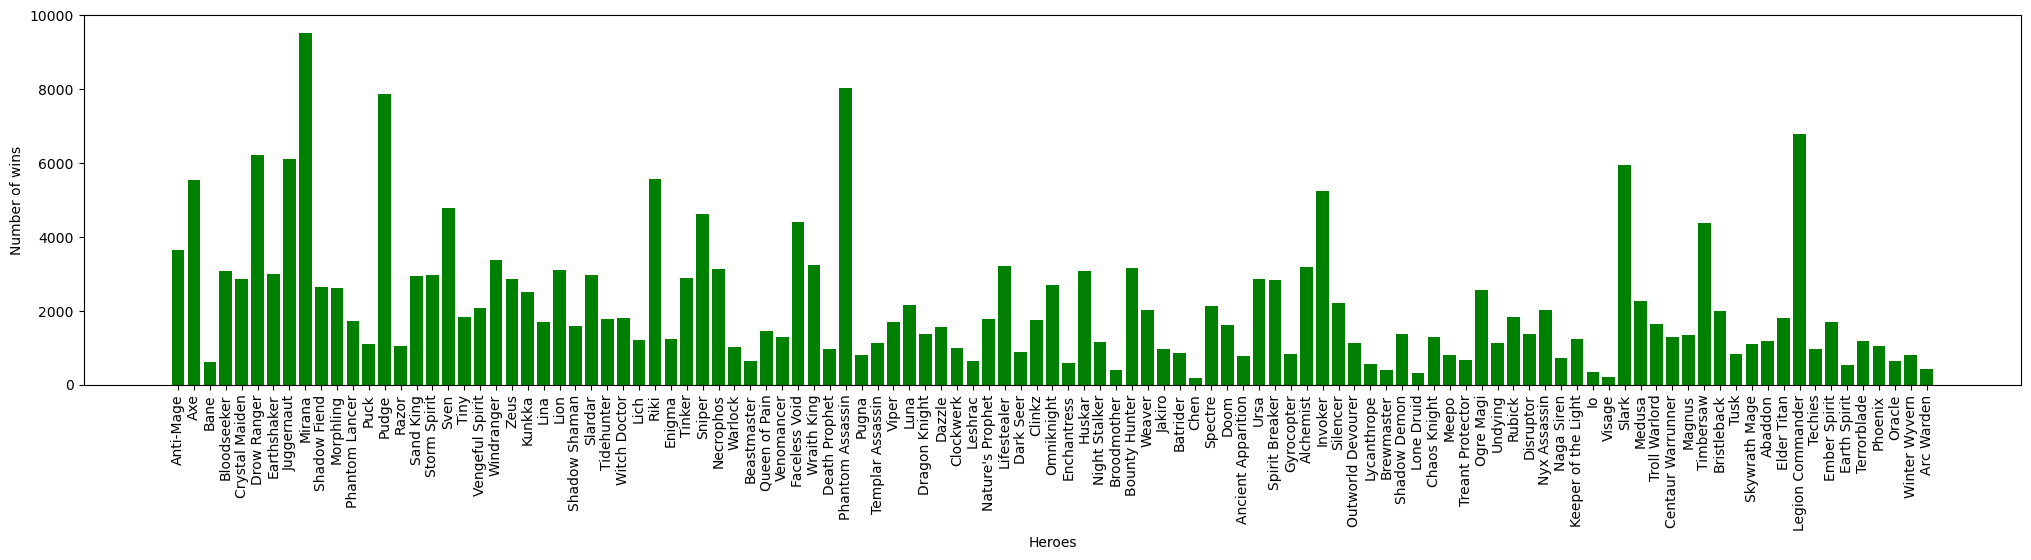

In [4]:
wins=[]
losses=[]
for i in db.columns[4:]:
    win_count = len(db[(db["result"]==1) & (db[i]==1)])+len(db[(db["result"]==-1)&db[i]==-1])
    loss_count= len(db[(db["result"]==1) & (db[i]==-1)])+len(db[(db["result"]==-1)&(db[i]==1)])
    wins.append(win_count)
    losses.append(loss_count)
plt.figure().set_figwidth(25)
plt.bar(db.columns[4:],wins,color="g")
plt.xlabel("Heroes")
plt.ylabel("Number of wins")
plt.xticks(rotation=90)
plt.show()

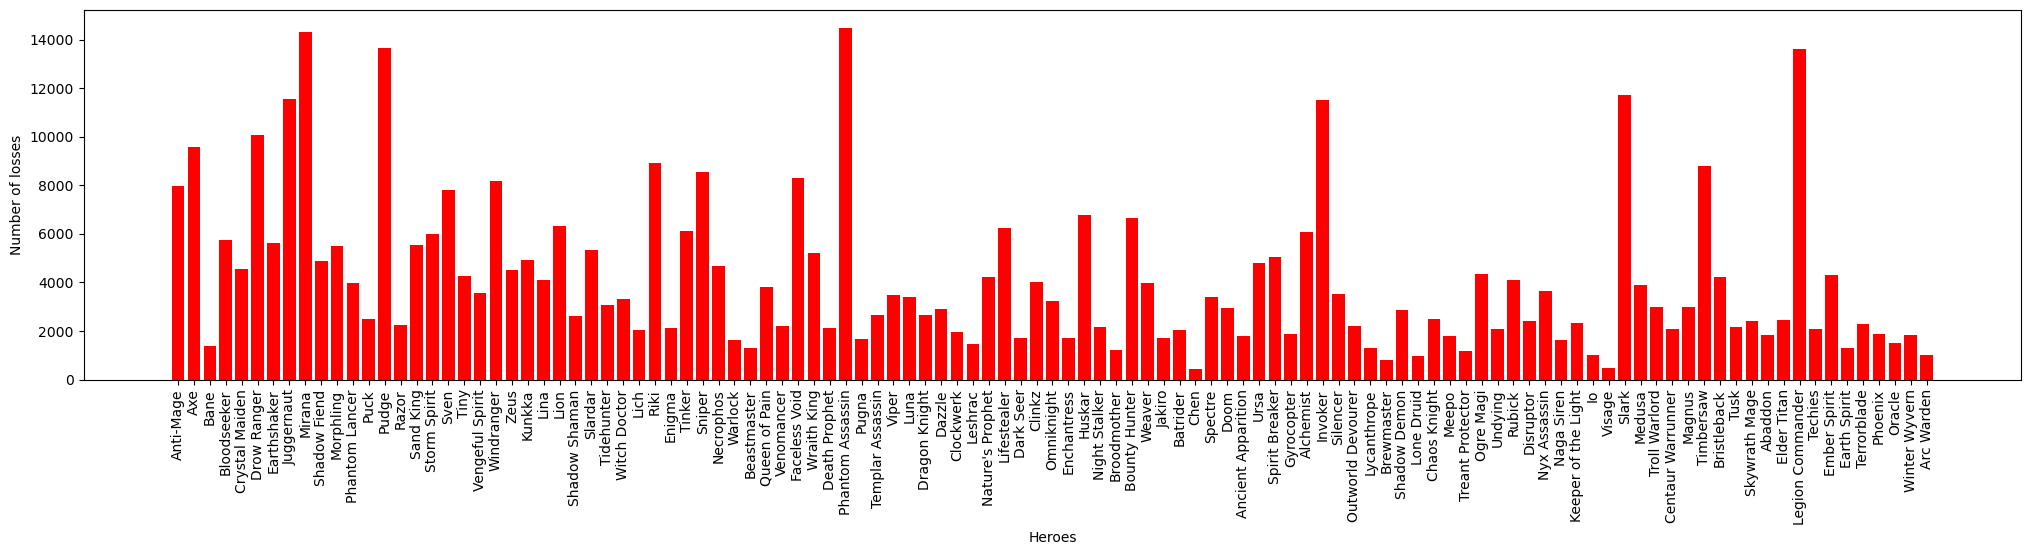

In [5]:
plt.figure().set_figwidth(25)
plt.bar(db.columns[4:],losses,color="r")
plt.xlabel("Heroes")
plt.ylabel("Number of losses")
plt.xticks(rotation=90)
plt.show()

Plot of the hero win and loss percentages.

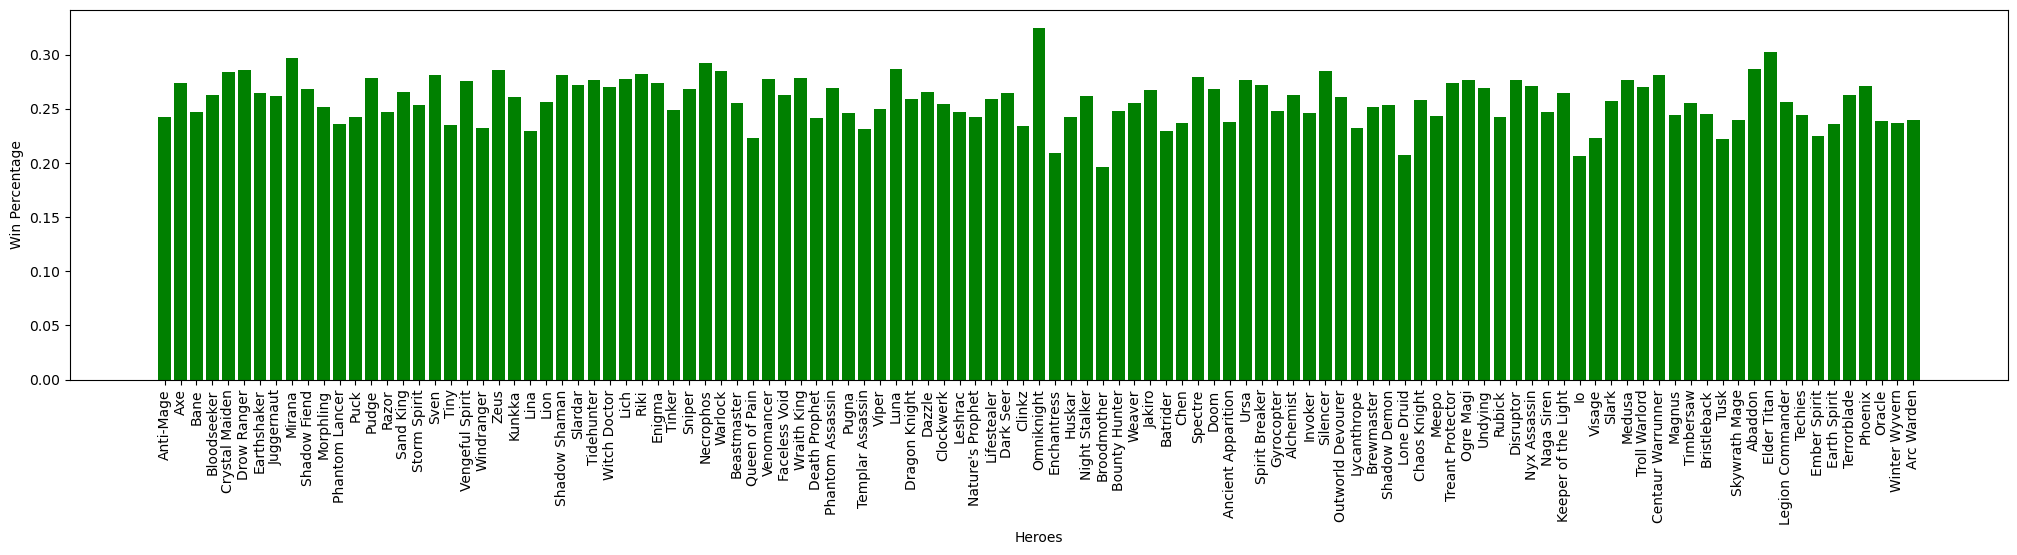

In [6]:

freq=np.array(freq_y)
wins=np.array(wins)
losses=np.array(losses)
winperc= wins/freq
lossperc=losses/freq
plt.figure().set_figwidth(25)
plt.xticks(rotation=90)
plt.ylabel("Win Percentage")
plt.xlabel("Heroes")
plt.bar(db.columns[4:],winperc,color="g")
plt.show()
        


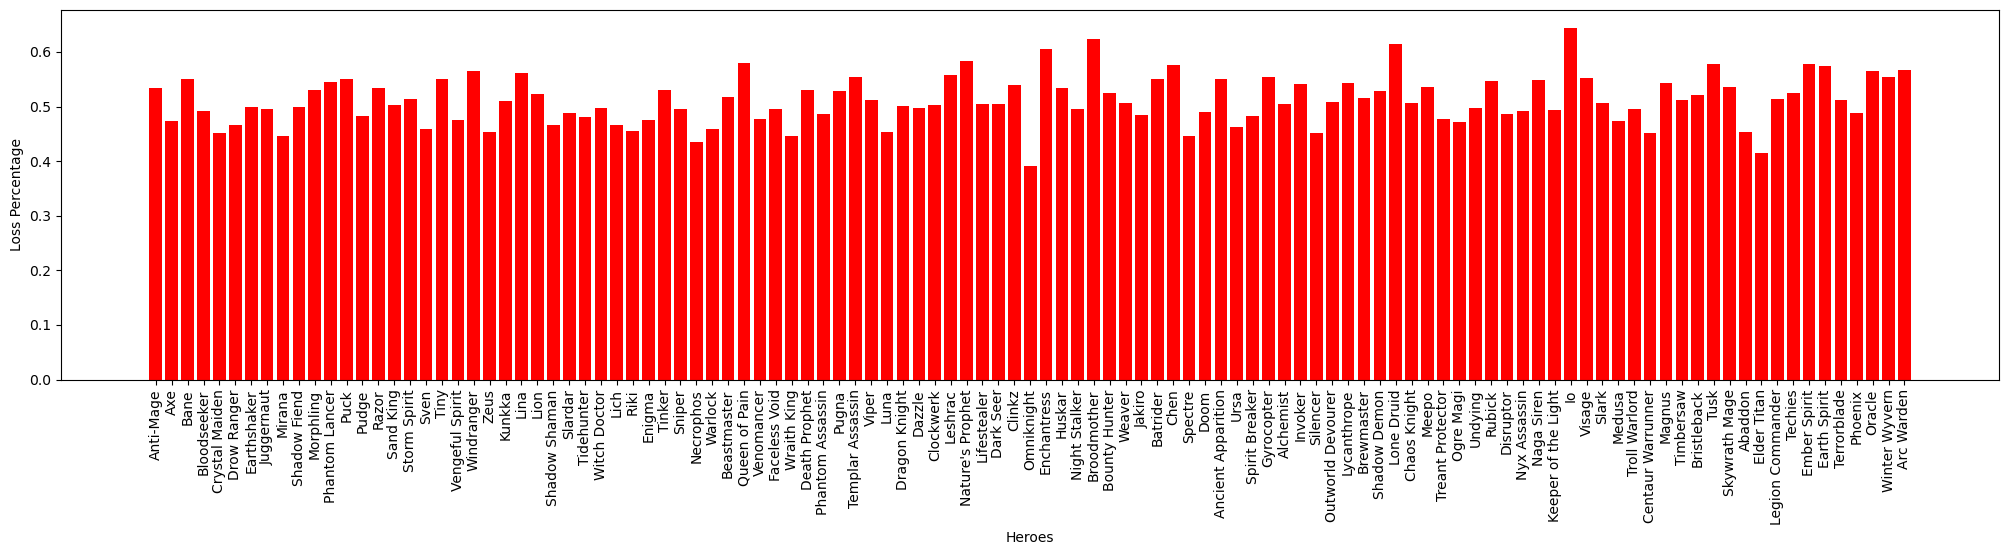

In [7]:
plt.figure().set_figwidth(25)
plt.bar(db.columns[4:],lossperc,color="r")
plt.xticks(rotation=90)
plt.xlabel("Heroes")
plt.ylabel("Loss Percentage")
plt.show()

Used one-hot encoding to represent the categorical variables and transformed the dataframe.

In [8]:
labels=db[["result"]]
db=db.drop(["result"],axis=1)

cat_attribs=db.columns[:]
full_pipeline=ColumnTransformer([
    ("cat",OneHotEncoder(),cat_attribs)
])

frame_prepared=full_pipeline.fit_transform(db)

test_labels=test[["result"]]
test=test.drop(["result"],axis=1)
test_prepared=full_pipeline.transform(test)

Fitted the training data into a Logistic Regression model and evaluated its performance on the test data using 3-fold cross validation

In [9]:
log_reg=LogisticRegression(solver='lbfgs',max_iter=100000)
log_reg.fit(frame_prepared, labels)
y_test_pred = cross_val_predict(log_reg,test_prepared,test_labels, cv=3)
accuracy=accuracy_score(test_labels,y_test_pred)
precision=precision_score(test_labels, y_test_pred)
recall=recall_score(test_labels,y_test_pred)
f1=f1_score(test_labels,y_test_pred)
print(f"Logistic Regression: accuracy={accuracy:.5f}, precision={precision:.5f}, recall={recall:.5f}, f1score={f1:.5f}")

Logistic Regression: accuracy=0.58020, precision=0.59759, recall=0.65722, f1score=0.62598


Plot of the P-R curve and the ROC curve

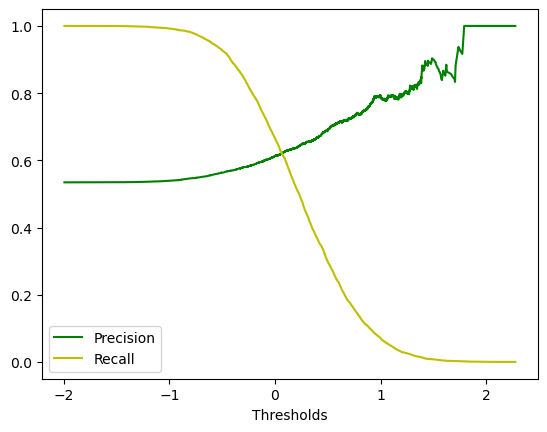

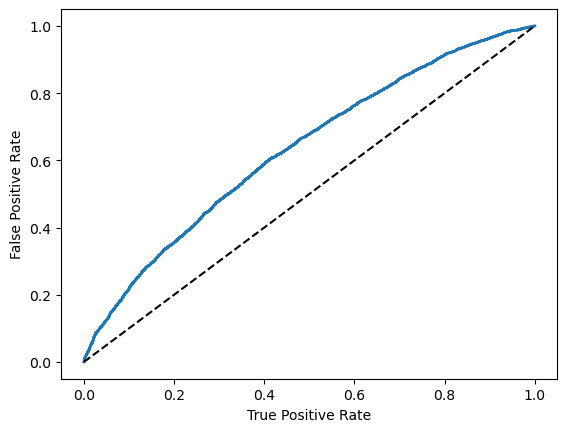

In [10]:
y_scores=log_reg.decision_function(test_prepared)
precisions,recalls,thresholds=precision_recall_curve(test_labels,y_scores)
def plot_pr(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'g',label="Precision")
    plt.xlabel('Thresholds')
    plt.plot(thresholds, recalls[:-1], 'y',label="Recall")
    plt.legend()
    plt.show()
plot_pr(precisions,recalls,thresholds)
tpr,fpr,thresholds=roc_curve(test_labels,y_scores)
def plot_roc(tpr,fpr):
    plt.plot(tpr,fpr, linewidth=2)
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--') 
plot_roc(tpr,fpr)

Similarly fitting the data into a Gaussian Naive Bayes Model and evaluating its performance on the test set.

In [11]:
bayes=GaussianNB()
bayes.fit(frame_prepared.toarray(),labels)
y_test_pred= cross_val_predict(bayes, test_prepared.toarray(),test_labels, cv=3)
accuracy=accuracy_score(test_labels,y_test_pred)
precision=precision_score(test_labels, y_test_pred)
recall=recall_score(test_labels,y_test_pred)
f1=f1_score(test_labels,y_test_pred)
print(f"Naive Bayes: accuracy={accuracy:.5f}, precision={precision:.5f}, recall={recall:.5f}, f1score={f1:.5f}")

Naive Bayes: accuracy=0.54688, precision=0.58650, recall=0.51636, f1score=0.54920


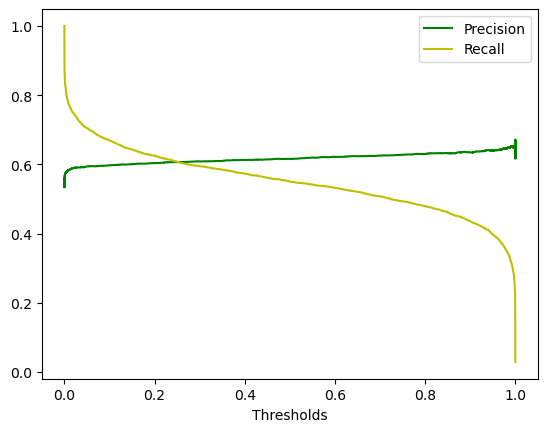

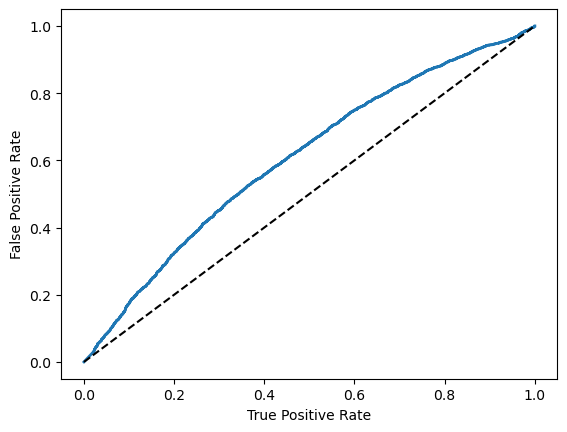

In [12]:
y_scores=bayes.predict_proba(test_prepared.toarray())[:,1]
precisions,recalls,thresholds=precision_recall_curve(test_labels,y_scores)
plot_pr(precisions,recalls,thresholds)
tpr,fpr,thresholds=roc_curve(test_labels,y_scores)
plot_roc(tpr,fpr)

Finally fitting the data into a Random Forest Classifier which uses 100 decision trees and evaluating its performance.

In [13]:
forest=RandomForestClassifier(n_estimators=100)
forest.fit(frame_prepared, labels)
y_test_pred = cross_val_predict(forest, test_prepared,test_labels, cv=3)
accuracy=accuracy_score(test_labels,y_test_pred)
precision=precision_score(test_labels, y_test_pred)
recall=recall_score(test_labels,y_test_pred)
f1=f1_score(test_labels,y_test_pred)
print(f"Random Forest: accuracy={accuracy:.5f}, precision={precision:.5f}, recall={recall:.5f}, f1score={f1:.5f}")

Random Forest: accuracy=0.55815, precision=0.57400, recall=0.67248, f1score=0.61935


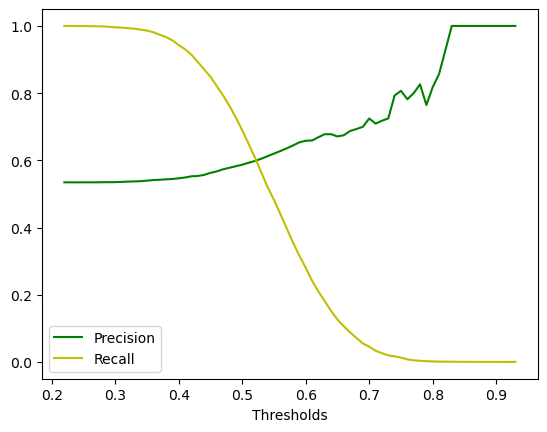

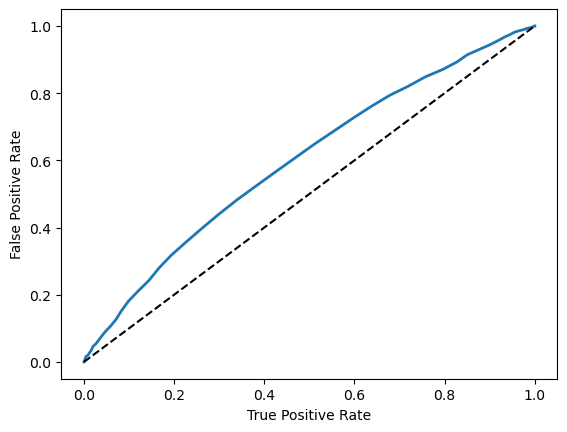

In [14]:
y_scores=forest.predict_proba(test_prepared)[:,1]
precisions,recalls,thresholds=precision_recall_curve(test_labels,y_scores)
plot_pr(precisions,recalls,thresholds)
tpr,fpr,thresholds=roc_curve(test_labels,y_scores)
plot_roc(tpr,fpr)

Model | Accuracy | Precision | Recall | F1 Score
| --- | --- | --- | --- | --- |
Logistic Regression | 0.58020 | 0.59759 | 0.65722 | 0.62598
Naive Bayes | 0.54688 | 0.58650 | 0.51636 | 0.54920
Random Forest | 0.55815 | 0.57400 | 0.67248 | 0.61935